# Opdracht Lectoraat Energietransitie
## 1. Business Understanding
Doel: beste fit te maken voor de `thermal inertia (tau)[h]` for each of 23 Assendorp homes.

* Pandas dataframe with learned thermal inertia per home per cooling period; per row: 
    ```
    home_id, 
    starttime, endtime, 
    start_temp_in__degC, end_temp_in__degC, 
    start_temp_out_e__degC, end_temp_out__degC, 
    tau__h
    ```
* Pandas dataframe with average thermal inertia per home per ISO calendar week;
* Visualize temporal variation/trends/patterns per home per ISO calendar week;
* Visualize similarities/difference amongst homes & your assessment;
* Your code to learn thermal inertia for all suitable cooling periods for all 23 homes monitored
  * Preferably as a Pull Request in GitHub from a fork of our repository
* Bonus / Additional challenge? Check/ improve pre-processing on raw data
  * Add time-series based outlier detection & filtering (e.g. based on tsmoothie?)
  * Improved KNMI wheather data
    * Faster geospatial interpolation
    * Proper handling of transition from summer to winter time


## 2. Data Understanding
### 2.1. Libraries importeren
We gebruiken [`pandas`](https://pandas.pydata.org/) voor de algemene dataverwerking, [`matplotlib`](https://matplotlib.org/stable/tutorials/pyplot.html) ter datavisualisatie, [`SciPy`](https://scipy.org/) voor het vinden van het optimum, [`historicdutchdata`](https://pypi.org/project/historicdutchweather/) voor KNMI-weerdata en een aantal utilities.

In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from datetime import datetime

from scipy.optimize import minimize

import historicdutchweather
from datetime import datetime, time, timedelta

import glob
import os

### 2.2. Weerdata
Dit doen we om de buitentemperatuur te kunnen bepalen.

In [132]:
# x = datetime(2022,1,16)
# y = datetime(2022,1,17)
# lat, lon = 52.50655, 6.09961
# df = historicdutchweather.get_local_weather(x, y, lat, lon, metrics=['T', 'FH', 'N'])

df_weather = pd.read_csv('weather.csv')

df_weather = df_weather.rename(columns={"Unnamed: 0": "time"})
df_weather['time'] = pd.to_datetime(df_weather['time'])
df_weather = df_weather.set_index('time')

df_weather = df_weather.drop(['DD', 'Q', 'DR', 'RH', 'U'], axis=1)

df_weather

,T,FH,N
time,,,
2020-04-10 00:00:00+00:00,4.461015,2.604330,1.947349
2020-04-10 01:00:00+00:00,4.014926,2.604330,7.088386
2020-04-10 02:00:00+00:00,3.437970,2.249255,8.000000
2020-04-10 03:00:00+00:00,3.019567,2.124627,8.000000
2020-04-10 04:00:00+00:00,3.175657,2.355075,8.000000
...,...,...,...
2022-09-05 19:00:00+00:00,18.193627,0.834777,7.087373
2022-09-05 20:00:00+00:00,18.629837,1.728957,8.000000
2022-09-05 21:00:00+00:00,18.296253,1.853584,8.000000


### 2.3. Huisdata
De huizen hebben elk een uniek nummer in de dataset (die niet overeenkomt met het daadwerkelijke huisnummer).

In [133]:
all_files = glob.glob(os.path.join("data/raw-measurements/", "*.csv"))
all_files

['data/raw-measurements/886307_raw_measurements.csv',
 'data/raw-measurements/857477_raw_measurements.csv',
 'data/raw-measurements/809743_raw_measurements.csv',
 'data/raw-measurements/899510_raw_measurements.csv',
 'data/raw-measurements/811308_raw_measurements.csv',
 'data/raw-measurements/822479_raw_measurements.csv',
 'data/raw-measurements/879481_raw_measurements.csv',
 'data/raw-measurements/895671_raw_measurements.csv',
 'data/raw-measurements/845966_raw_measurements.csv',
 'data/raw-measurements/839440_raw_measurements.csv',
 'data/raw-measurements/830088_raw_measurements.csv',
 'data/raw-measurements/881611_raw_measurements.csv',
 'data/raw-measurements/817341_raw_measurements.csv',
 'data/raw-measurements/829947_raw_measurements.csv',
 'data/raw-measurements/873985_raw_measurements.csv',
 'data/raw-measurements/815925_raw_measurements.csv',
 'data/raw-measurements/803422_raw_measurements.csv',
 'data/raw-measurements/831062_raw_measurements.csv',
 'data/raw-measurements/8642

Deze data is verdeeld over `measurements` en `properties`:

In [134]:
houses = {}

for file in all_files:
    # format is data/raw-measurements/{house}_raw_measurements.csv
    house = int(file.split("/")[-1].split("_")[0])

    houses[house] = {
        "measure_df": pd.read_csv(file, engine='pyarrow'),
        #                                       ^~~~~~~ zorgt ervoor dat UTC
        #                                               genormaliseerd wordt
        "props_df": pd.read_csv(f"data/raw-properties/{house}_raw_properties.csv", engine='pyarrow')
    }


### 2.4. Data-begrip
Opvallend is dat de `measurements` alle eigenschappen bevatten:

In [135]:
eerste_huisnummer = list(houses.keys())[0]
eerste_huis = houses[eerste_huisnummer]

eerste_huis["measure_df"].info()
eerste_huis["measure_df"].head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209501 entries, 0 to 209500
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype             
---  ------       --------------   -----             
 0   id           209501 non-null  int64             
 1   device_name  209501 non-null  object            
 2   source       209501 non-null  object            
 3   timestamp    209501 non-null  datetime64[s, UTC]
 4   property     209501 non-null  object            
 5   value        209501 non-null  object            
 6   unit         162001 non-null  object            
dtypes: datetime64[s, UTC](1), int64(1), object(5)
memory usage: 11.2+ MB


,id,device_name,source,timestamp,property,value,unit
0,886307,TWOMES-612C50,OpenTherm-Monitor,2021-12-16 20:31:11+00:00,temp_in__degC,17.67,°C
1,886307,TWOMES-612C50,OpenTherm-Monitor,2021-12-16 20:31:11+00:00,temp_set__degC,15.00,°C
2,886307,TWOMES-612C50,OpenTherm-Monitor,2021-12-16 20:36:33+00:00,temp_in__degC,17.67,°C
3,886307,TWOMES-612C50,OpenTherm-Monitor,2021-12-16 20:36:33+00:00,temp_set__degC,18.00,°C
4,886307,TWOMES-612C50,OpenTherm-Monitor,2021-12-16 20:41:38+00:00,temp_in__degC,17.67,°C


Terwijl de `properties` een soort gepivoteerd beeld is van de `measurements`, samengevoegd op één tijdstip.

In [136]:
eerste_huis["props_df"].info()
eerste_huis["props_df"].head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46425 entries, 0 to 46424
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype             
---  ------                   --------------  -----             
 0   id                       46425 non-null  int64             
 1   source                   46425 non-null  object            
 2   timestamp                46425 non-null  datetime64[s, UTC]
 3   e_ret_hi_cum__kWh        23750 non-null  float64           
 4   e_ret_lo_cum__kWh        23750 non-null  float64           
 5   e_timestamp__YYMMDDhhmX  23750 non-null  object            
 6   e_use_hi_cum__kWh        23750 non-null  float64           
 7   e_use_lo_cum__kWh        23750 non-null  float64           
 8   g_timestamp__YYMMDDhhmX  23750 non-null  object            
 9   g_use_cum__m3            23750 non-null  float64           
 10  temp_in__degC            22372 non-null  float64           
 11  temp_set__degC           20879 non-null  

,id,source,timestamp,e_ret_hi_cum__kWh,e_ret_lo_cum__kWh,e_timestamp__YYMMDDhhmX,e_use_hi_cum__kWh,e_use_lo_cum__kWh,g_timestamp__YYMMDDhhmX,g_use_cum__m3,temp_in__degC,temp_set__degC
0,886307,DSMR-P1-gateway-TinTsTrCO2,2021-12-16 07:41:13+00:00,0.001,0.0,211216084137W,4073.994,2891.951,211216080000W,2480.849,NaN,NaN
1,886307,DSMR-P1-gateway-TinTsTrCO2,2021-12-16 07:46:13+00:00,0.001,0.0,211216084637W,4074.162,2891.951,211216080000W,2480.849,NaN,NaN
2,886307,DSMR-P1-gateway-TinTsTrCO2,2021-12-16 07:51:13+00:00,0.001,0.0,211216085137W,4074.330,2891.951,211216080000W,2480.849,NaN,NaN
3,886307,DSMR-P1-gateway-TinTsTrCO2,2021-12-16 07:56:13+00:00,0.001,0.0,211216085637W,4074.502,2891.951,211216080000W,2480.849,NaN,NaN
4,886307,DSMR-P1-gateway-TinTsTrCO2,2021-12-16 08:01:13+00:00,0.001,0.0,211216090137W,4074.672,2891.951,211216080000W,2480.849,NaN,NaN


Ook kunnen we zien dat de `props_df` helaas niet altijd de binnentemperatuur bevat:

In [137]:
print("Eerste regels:", eerste_huis["props_df"]["temp_in__degC"].head(), sep="\n")
print("Maximum:", eerste_huis["props_df"]["temp_in__degC"].max())
print("Maximum:", eerste_huis["props_df"]["temp_in__degC"].min())

Eerste regels:
0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: temp_in__degC, dtype: float64
Maximum: 104.16
Maximum: -95.36


In [138]:
eerste_huis_temperatuur = eerste_huis["measure_df"][eerste_huis["measure_df"]["property"] == 'temp_in__degC']["value"].astype(float)
print("Eerste regels:", eerste_huis_temperatuur.head(), sep="\n")
print("Maximum:", eerste_huis_temperatuur.max())
print("Minimum:", eerste_huis_temperatuur.min())
print("Mediaan:", eerste_huis_temperatuur.median())

Eerste regels:
0    17.67
2    17.67
4    17.67
6    18.02
8    18.34
Name: value, dtype: float64
Maximum: 104.16
Minimum: -95.36
Mediaan: 16.51


## 3. Data Preparation
### 3.1. Berekenen van de gevoelstemperatuur

In [139]:
buitenwarmte_df = df_weather.rename(columns={'T': 'actuele_buitentemp', 'FH': 'windsnelheid'})

def gevoelsTemperatuur(row):
    temp = row['actuele_buitentemp']
    wind = row['windsnelheid']
    return temp - (2/3 * wind)

buitenwarmte_df['T_out'] = buitenwarmte_df.apply(gevoelsTemperatuur, axis=1)

### 3.2. Resampelen van huisdata
Omdat sommige datapunten juist snel achter elkaar zitten, en andere juist ver uit elkaar, is het handig om de data te resamplen. Dit betekent dat we de data opnieuw gaan indelen, zodat we een gelijke verdeling krijgen

In [140]:
RESAMPLE_INTERVAL = pd.Timedelta(5, unit='minutes')

def resample(measure_df: pd.DataFrame, props_df: pd.DataFrame) -> pd.DataFrame:
    # We pakken eerst de measure_df, omdat die de binnentemperatuur (temp_in__degC) bevat
    binnentemperatuur = measure_df.copy()
    binnentemperatuur = binnentemperatuur[binnentemperatuur['property'] == 'temp_in__degC']
    binnentemperatuur.set_index('timestamp', inplace=True)
    binnentemperatuur['value'] = binnentemperatuur['value'].astype(float)
    binnentemperatuur = binnentemperatuur.drop(columns=['device_name','source', 'unit', 'property'])
    binnentemperatuur = binnentemperatuur.resample(RESAMPLE_INTERVAL).mean()

    # Nu pakken we de properties, omdat die de stroom- en gasgebruik bevat
    eigenschappen_df = props_df.copy()
    eigenschappen_df.set_index('timestamp', inplace=True)
    eigenschappen_df = eigenschappen_df.drop(columns=['id', 'source', 'e_timestamp__YYMMDDhhmX', 'g_timestamp__YYMMDDhhmX', 'temp_in__degC'])
    eigenschappen_df['stroomgebruik'] = eigenschappen_df['e_use_lo_cum__kWh'] + eigenschappen_df['e_use_hi_cum__kWh']
    eigenschappen_df = eigenschappen_df.resample(RESAMPLE_INTERVAL).mean()

    # g_use_cum__m3 should be diff'ed with the previous value to get the actual usage, since it is cumulative
    eigenschappen_df['g_use_cum__m3'] = eigenschappen_df['g_use_cum__m3'].diff()
    eigenschappen_df['stroomgebruik'] = eigenschappen_df['stroomgebruik'].diff()

    # Nu voegen we de twee dataframes samen
    binnentemperatuur = pd.merge(binnentemperatuur, eigenschappen_df, left_index=True, right_index=True, how='left')
    return binnentemperatuur

# Resample alle huizen die we opgehaald hebben
houses_resampled = {}
for house, data in houses.items():
    resampled = resample(data["measure_df"], data["props_df"])

    if resampled is None:
        print(f"Skipping house {house} because it has no data")
        continue

    houses_resampled[house] = resampled

### 3.3. Samenvoegen van huisdata en temperatuurdata
Om de data te kunnen analyseren, moeten we de [huisdata](#31-berekenen-van-de-gevoelstemperatuur) en [temperatuurdata](#32-resampelen-van-huisdata) samenvoegen. Ze zijn al geresampled, dus we kunnen ze samenvoegen op basis van de tijd.

In [141]:
gecombineerd_houses = {}
for house, binnentemperatuur in houses_resampled.items():
    gecombineerde_df = pd.merge(buitenwarmte_df, binnentemperatuur, left_index=True, right_index=True, how='inner')
    gecombineerde_df = gecombineerde_df.rename(columns={'value': 'binnentemperatuur'})

    gecombineerde_df.index.name = 'timestamp'
    gecombineerd_houses[house] = gecombineerde_df

### 3.4. Filteren van datapunten die gelden wanneer het nacht is
Omdat we geen data (in CSV-formaat) konden vinden van accurate nachtsbereiken (zonsopgang en -ondergang), hebben we het vroegste tijdstip gepakt waarop de zon opkomt en het laatste tijdstip waarop de zon ondergaat. Dit hebben we gedaan voor de maanden mei, juni, juli en augustus. De data is afkomstig van de website van de [KNMI](https://cdn.knmi.nl/system/ckeditor/attachment_files/data/000/000/288/original/tijden_van_zonopkomst_en_-ondergang_2024.pdf).

In [142]:
gefilterde_houses = {}

for house, gecombineerde_df in gecombineerd_houses.items():
    # Filteren of het donker is, bij N>7 is de bewolkingsgraad 'zwaar bewolkt' of 'betrokken'.
    gefilterde_df = gecombineerde_df.loc[gecombineerde_df['N'] > 7]

    # Filteren of het nacht is, door het jaar heen is het uiterst vroegste zonsopkomst om 5:00 en het laatste zonsondergang om 22:00
    zonsopkomst = time(5, 0)
    zonsondergang = time(22, 0)
    gefilterde_df = gefilterde_df[(gefilterde_df.index.to_series().dt.time > zonsondergang) | (gefilterde_df.index.to_series().dt.time < zonsopkomst)]

    gefilterde_houses[house] = gefilterde_df

### 3.5. Groeperen op nacht
De data die we per huis hebben verzameld geldt nu nog over alle nachten, dus die filteren we hier uit. Een nacht geldt hier van de avond ervoor tot de ochtend erna.

In [143]:
def createNacht(row: pd.Series):
    timestamp: pd.Timestamp = row.name
    time = timestamp.time()
    if time < zonsopkomst:
        return timestamp.date() - timedelta(days=1)
    else:
        return timestamp.date()

gegroepeerde_houses = {}

for house, gefilterde_df in gefilterde_houses.items():
    # 'nacht' is dus de dag van de start, niet de dag van de einddatum van de nacht
    gefilterde_df['nacht'] = gefilterde_df.apply(createNacht, axis=1)
    gegroepeerde_houses[house] = gefilterde_df

### 3.6. Uitfilteren van ongeldige nachten
De verwarming moet uitstaan, op GitHub staat:

> The home is heated by a gas-fired heating boiler that is controlled by a thermostat and is not predominantly heated via other
> means.

Daarom kunnen we simpelweg het gasverbruik van de woning gebruiken om te bepalen of de verwarming aanstaat. Als $gasverbruik \approx 0$ is, dan staat de verwarming uit. Als $gasverbruik \gt 0$ is, dan staat de verwarming aan. Ook andere apparatuur die gas verbruikt, zoals een douche, draagt bij aan de gegenereerde warmte en geldt dus als verwarming.

// Omdat er over het algemeen altijd stroom gebruikt wordt door bijvoorbeeld de koelkast,
// WiFi-router, en lekstroom, kiezen we voor de mediaan van het stroomgebruik als maximum.
Bij het stroomverbruik is het iets anders. Er wordt over het algemeen altijd stroom gebruikt door bijvoorbeeld de koelkast, WiFi-router, en lekstroom. Daarom kiezen we voor het mediaan $\Delta stroomgebruik \gt \overline{stroomgebruik}$  als maximum. 

In [166]:
aantal_nachten = 0
nachten = []

for house, gefilterde_df in gegroepeerde_houses.items():
    # Omdat er over het algemeen altijd stroom gebruikt wordt door bijvoorbeeld de koelkast,
    # WiFi-router, en lekstroom, kiezen we voor de mediaan van het stroomgebruik als maximum.
    max_stroom_gebruik = gefilterde_df['stroomgebruik'].median()

    # 0.1 is gekozen omdat door resampling/interpolatie er soms een klein beetje gasverbruik is
    # zonder dat dat relevant is.
    max_gas_gebruik = 0.1

    for (nacht, nacht_values_df) in gefilterde_df.groupby('nacht'):
        aantal_nachten += 1 # Dit wordt bijgehouden om het percentage "juiste" nachten te filteren

        gas_gebruik = nacht_values_df['g_use_cum__m3'].sum()
        if gas_gebruik > max_gas_gebruik:
            continue

        stroom_gebruik = nacht_values_df['stroomgebruik'].mean()
        if stroom_gebruik > max_stroom_gebruik:
            continue

        verschilTussenMinEnMaxTemp = nacht_values_df['binnentemperatuur'].max() - nacht_values_df['binnentemperatuur'].min()
        if verschilTussenMinEnMaxTemp < 1:
            continue

        # Als huizen niet minstens 3 data punten hebben, heeft de gradient descent weinig nut.
        dataPunten = len(nacht_values_df.values)
        if dataPunten <= 3:
            continue

        nachten.append((house, nacht, nacht_values_df))

print(f"{int(len(nachten) / aantal_nachten * 100)}% van de nachten zijn geschikt voor analyse")

13% van de nachten zijn geschikt voor analyse


## 4. Modeling
### 4.1. Modelfunctie
Het model is aangeleverd vanuit school:

In [145]:
def model(tau:float, df:pd.DataFrame, T_in_at_start:float) -> pd.Series:
    """Note: assumes tau in hours.
       Please make sure that the data has a small time interval, otherwise inaccuracies will occur."""

    # Convert tau from hours to seconds
    tau = tau * 3600

    # Calculate the time difference in seconds (assumes constant interval)
    times = df.index
    timediff = (times[1] - times[0]).seconds

    # Initial temperature gets copied in for the first record
    T = [T_in_at_start]

    # Then we loop over all other steps
    for timestamp in times[1:]:

        # Get the relevant data
        T_in = T[-1]
        T_out = df.loc[timestamp, 'T_out']

        # The equation that does all the work
        T_change = -(T_in - T_out) * timediff / tau

        # Save to array
        T.append(T_in + T_change)

    return pd.Series(data=T, index=times, name='T_in')


### 4.2. Cost-functie
Simpele Mean Squared Error tussen de verwachtte binnentemperatuur en de daadwerkelijke temperatuur. Hiermee kunnen we $\tau$ berekenen.

In [146]:
# Mean Squared Error
def MSE(y1, y2) -> float:
    return sum((y1 - y2)**2) / len(y1)

# Tau is het aantal uur dat het duurt voor het verhalveren van de temperatuur
def cost_function(tau: float, df: pd.DataFrame):
    # De temperatuur aan het begin van de nacht
    T_in_at_start = df['binnentemperatuur'].iloc[0]

    # Bereken nu de temperatuur obv de tau
    y_model = model(tau, df, T_in_at_start)

    # Check het verschil tussen de verwachting (y_model) en de echte waarde (df['binnentemperatuur'])
    return MSE(y_model, df['binnentemperatuur'])

### 4.3. Fitten
Vervolgens kunnen we de `cost_function` loslaten op de dataset per huis, per nacht:

In [147]:
resultaten = {}

for (house, nacht, nacht_values_df) in nachten:
    if len(nacht_values_df.values) < 2:
        continue

    result = minimize(cost_function, 0.1, bounds=[(0, float('inf'))], args=(nacht_values_df))
    if house not in resultaten:
        resultaten[house] = {}
    resultaten[house][nacht] = result.x[0]

### 4.4. Visualisatie
Als laatste plotten we de nachten in één grafiek.

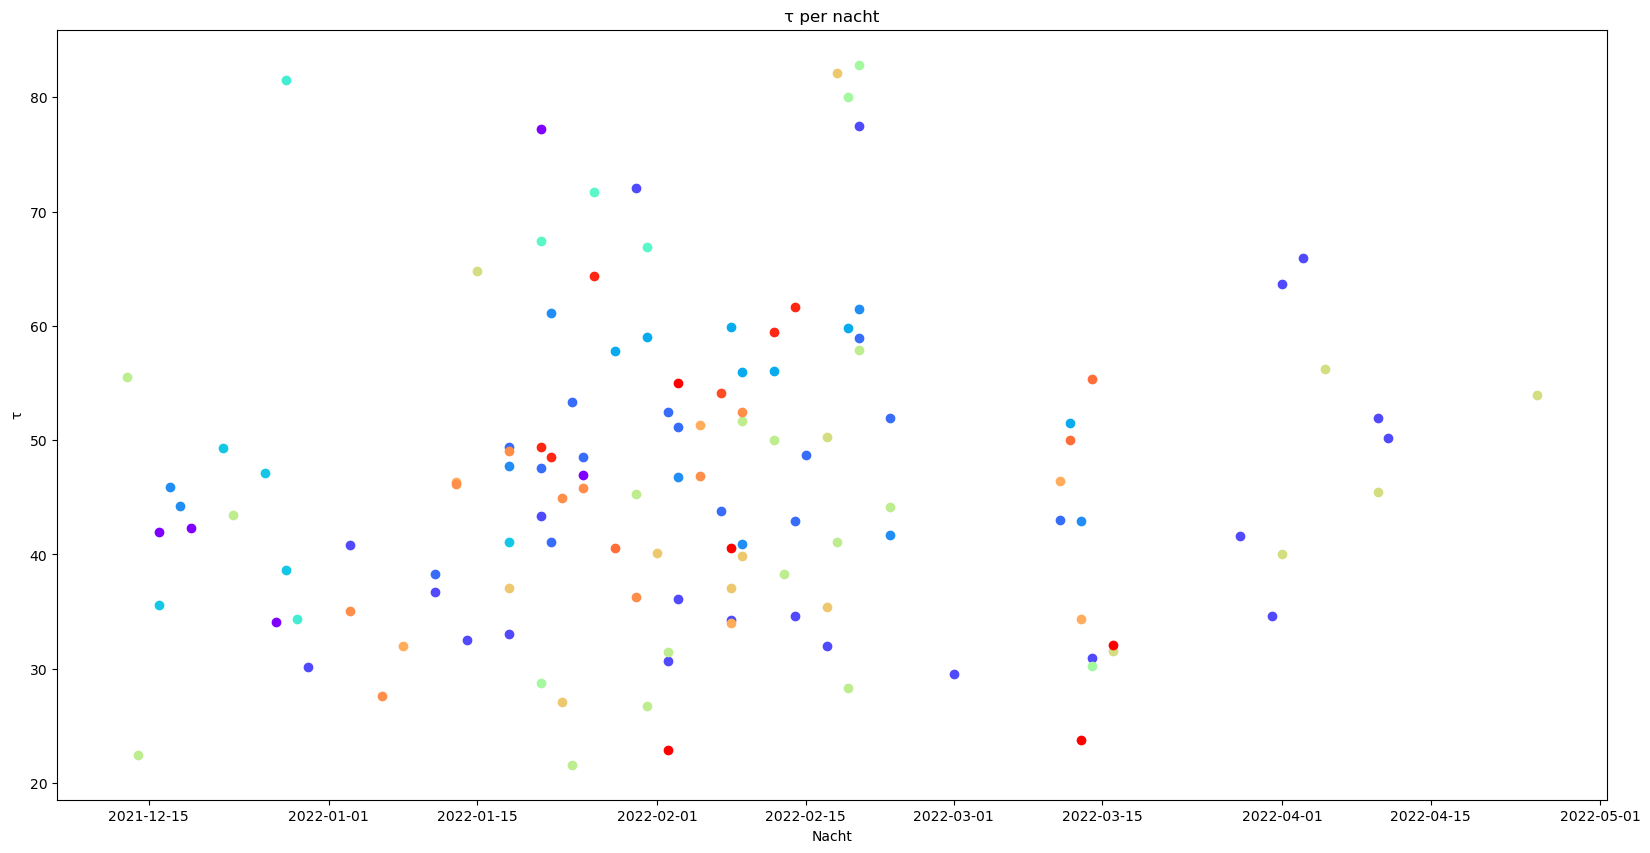

In [155]:
plt.figure(figsize=(20, 10))

colors = cm.rainbow(np.linspace(0, 1, len(resultaten)))

for color, house in zip(colors, resultaten.keys()):
    for nacht, tau in resultaten[house].items():
        if tau > 100:
            continue
        if tau < 0.5:
            continue
        plt.scatter(nacht, tau, color=color)

plt.xlabel("Nacht")
plt.ylabel("τ")
plt.title("τ per nacht")
plt.show()

Result=24.30080483665754
Result=42.96602266257677
Result=44.74026195998889
Result=48.08505759493854
Result=19.11643162667003
Result=42.34127611742491
Result=20.667791386411245
Result=55.45230350691199
Result=25.394171489500444
Result=48.90379128510802
Result=42.658826671544595
Result=25.66095947446843
Result=48.64539481829805
Result=54.161631645872674
Result=47.26074847050683
Result=34.85998354244203


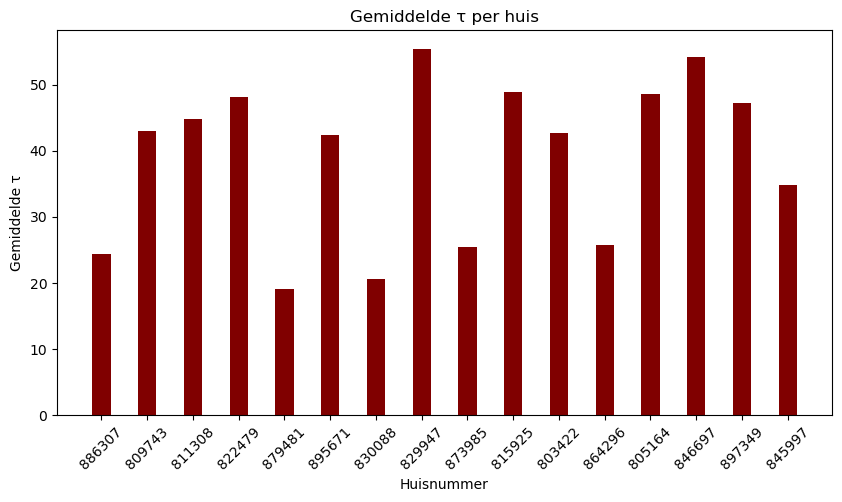

{'886307': 24.30080483665754,
 '809743': 42.96602266257677,
 '811308': 44.74026195998889,
 '822479': 48.08505759493854,
 '879481': 19.11643162667003,
 '895671': 42.34127611742491,
 '830088': 20.667791386411245,
 '829947': 55.45230350691199,
 '873985': 25.394171489500444,
 '815925': 48.90379128510802,
 '803422': 42.658826671544595,
 '864296': 25.66095947446843,
 '805164': 48.64539481829805,
 '846697': 54.161631645872674,
 '897349': 47.26074847050683,
 '845997': 34.85998354244203}

In [153]:
# Hoeveel huizen hebben een tau van minder dan 2 uur?

gemiddelde_tau = {}

for house, nachten in resultaten.items():
    if house == 839440 or house == 831062:
        continue

    result = sum(nachten.values()) / len(nachten.values())
    if result < 1:
        continue

    gemiddelde_tau[f'{house}'] = result

houses = list(gemiddelde_tau.keys())
values = list(gemiddelde_tau.values())

plt.clf()
plt.cla()
plt.close()

fig = plt.figure(figsize = (10, 5))

# # creating the bar plot
plt.bar(houses, values, color ='maroon',
        width = 0.4)

plt.xticks(rotation=45)
plt.xlabel("Huisnummer")
plt.ylabel("Gemiddelde τ")
plt.title("Gemiddelde τ per huis")
plt.show()

gemiddelde_tau

Tau: 41.969216536081355
<class 'pandas.core.series.Series'>


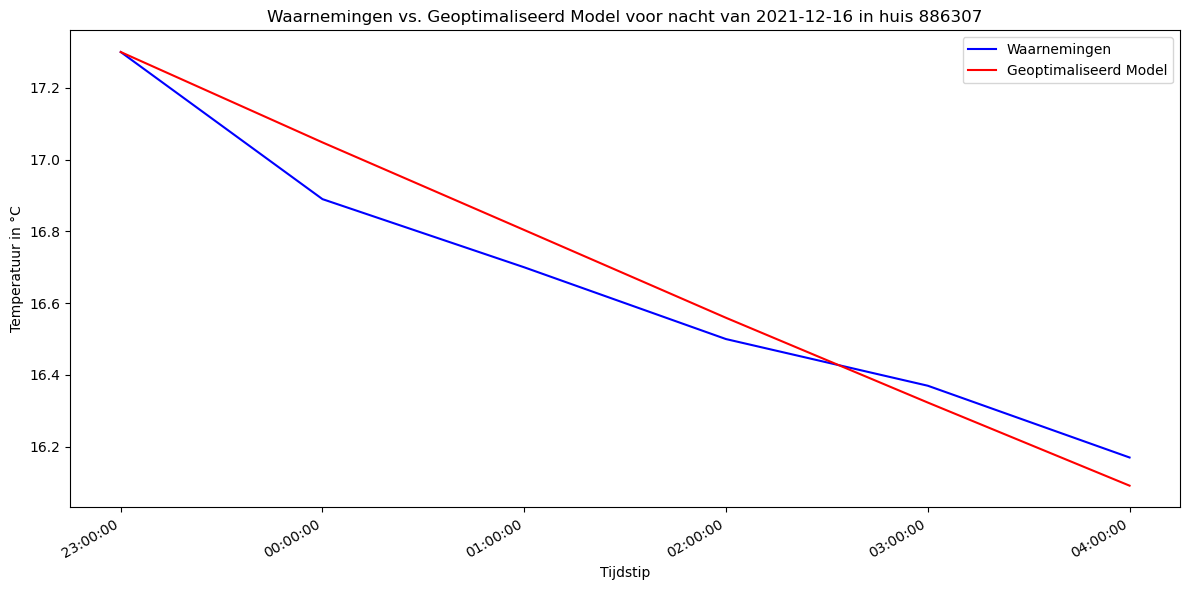

In [190]:
(huisnummer, datum, df) = nachten[0]
tau = resultaten[huisnummer][datum]
print("Tau:",tau)


# Bereken geoptimaliseerd model
tijdsreeks = df.index
# for x in df.index.copy().values:
#     x: pd.Timestamp = x
#     tijdsreeks.append(x.time())
optimized_model = model(tau, df, df["binnentemperatuur"].iloc[0])
print(type(optimized_model))

# Maak een nieuwe plot
fig = plt.figure(figsize=(12, 6))

# Plot waarnemingen
ax = plt.plot(tijdsreeks, df["binnentemperatuur"], label='Waarnemingen', color='blue')

# Plot geoptimaliseerd model
plt.plot(optimized_model, label='Geoptimaliseerd Model', color='red')

# Voeg titel, labels en legenda toe
plt.title(f'Waarnemingen vs. Geoptimaliseerd Model voor nacht van {datum} in huis {huisnummer}')
plt.xlabel('Tijdstip')
plt.ylabel('Temperatuur in °C')
plt.legend(loc='upper right')

import matplotlib.dates as mdates
myFmt = mdates.DateFormatter('%X')
fig.axes[0].xaxis.set_major_formatter(myFmt)

plt.gcf().autofmt_xdate()

# Toon de plot
plt.tight_layout()
plt.show()

Opvallendheden:
- Misschien kan de boilerdata gebruikt worden om te controleren of de verwarming aanstaat.
- Sommige nachten is het verschil tussen de hoogste en laagste temperatuur < 1. Dit kan betekenen dat of de verwarming de hele nacht aanstaat, of dat de bewoners de ramen open hebben, of niet thuiszijn, etc.